# How to combine control flow and state updates with Command

!!! info "Prerequisites"
    This guide assumes familiarity with the following:
  
    - [State](../../concepts/low_level/#state)
    - [Nodes](../../concepts/low_level/#nodes)
    - [Edges](../../concepts/low_level/#edges)
    - [Command](../../concepts/low_level/#command)

It can be useful to combine control flow (edges) and state updates (nodes). For example, you might want to BOTH perform state updates AND decide which node to go to next in the SAME node. LangGraph provides a way to do so by returning a `Command` object from node functions:

```python
def my_node(state: State) -> Command[Literal["my_other_node"]]:
    return Command(
        # state update
        update={"foo": "bar"},
        # control flow
        goto="my_other_node"
    )
```

This guide shows how you can do use `Command` to add dynamic control flow in your LangGraph app.

## Setup

First, let's install the required packages

In [1]:
%%capture --no-stderr
%pip install -U langgraph

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

Let's create a simple graph with 3 nodes: A, B and C. We will first execute node A, and then decide whether to go to Node B or Node C next based on the output of node A.

## Define graph

In [2]:
import random
from typing_extensions import TypedDict, Literal

from langgraph.graph import StateGraph, START
from langgraph.types import Command


# Define graph state
class State(TypedDict):
    foo: str


# Define the nodes


def node_a(state: State) -> Command[Literal["node_b", "node_c"]]:
    print("Called A")
    value = random.choice(["a", "b"])
    # this is a replacement for a conditional edge function
    if value == "a":
        goto = "node_b"
    else:
        goto = "node_c"

    # note how Command allows you to BOTH update the graph state AND route to the next node
    return Command(
        # this is the state update
        update={"foo": value},
        # this is a replacement for an edge
        goto=goto,
    )


# Nodes B and C are unchanged


def node_b(state: State):
    print("Called B")
    return {"foo": state["foo"] + "b"}


def node_c(state: State):
    print("Called C")
    return {"foo": state["foo"] + "c"}

We can now create the `StateGraph` with the above nodes. Notice that the graph doesn't have [conditional edges](../../concepts/low_level#conditional-edges) for routing! This is because control flow is defined with `Command` inside `node_a`.

In [3]:
builder = StateGraph(State)
builder.add_edge(START, "node_a")
builder.add_node(node_a)
builder.add_node(node_b)
builder.add_node(node_c)
# NOTE: there are no edges between nodes A, B and C!

graph = builder.compile()

!!! important

    You might have noticed that we used `Command` as a return type annotation, e.g. `Command[Literal["node_b", "node_c"]]`. This is necessary for the graph rendering and tells LangGraph that `node_a` can navigate to `node_b` and `node_c`.

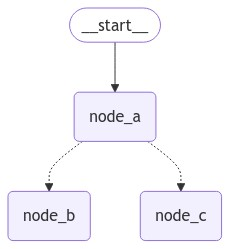

In [4]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

If we run the graph multiple times, we'd see it take different paths (A -> B or A -> C) based on the random choice in node A.

In [5]:
graph.invoke({"foo": ""})

Called A
Called C


{'foo': 'bc'}